In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

seaborn 0.10.1
pandas  1.1.4
numpy   1.19.5



In [3]:
import plot_utils as pu

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import requests

from io import StringIO

In [5]:
from collections import defaultdict

url = requests.get('https://docs.google.com/spreadsheets/d/1KO_wGiEagJ8PMO2BzSDI1IXHYO4RHZMMSWXlT48peiQ/export?format=csv')
csv_raw = StringIO(url.text)
df_truth = pd.read_csv(csv_raw)

inf_tax_file = "/mnt/btrfs/data/gtdb_95/gtdb_genomes_reps_r95/r95.gtdb.tax"

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
df_tax = pd.read_csv(inf_tax_file, names=["assembly_accession", "tax"], sep="\t")

df_tax["species"] = [";".join(_.split(";")[:7]) for _ in df_tax.tax]
df_tax["genus"] = [";".join(_.split(";")[:6]) for _ in df_tax.tax]
df_tax["family"] = [";".join(_.split(";")[:5]) for _ in df_tax.tax]

accession_to_genus = dict()
for t in df_tax.itertuples():
    accession_to_genus[t.assembly_accession] = t.genus.split(";")[-1]

In [7]:
from glob import glob
import os

files = glob("/mnt/btrfs/data/type_1/species_mc/b6_capitalist_split_by_sample/*.extra.tree.csv")

dfs = []
for file in files:
    name = '_'.join(os.path.basename(file).split('.')[:-4])
    df = pd.read_csv(file, index_col = 0)
    df['dataset'] = name
    dfs.append(df)
df_type_1_features = pd.concat(dfs)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (84,88,97,106,218,222,231,240) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
# Build the true species accessions
dd = defaultdict(set)

dd_genus = defaultdict(set)
for group, df in df_truth.groupby('dataset'):
    mask_nan = df_truth['database_accession'].astype(str) == 'nan'
    
    for row in df.loc[mask_nan].itertuples():
        # get the genus of the nans
        dd_genus[group].add("g__" + row.name.replace("_", " ").split()[0])
        dd_genus[group].add("g__" + row.homotypic_synonym.replace("_", " ").split()[0])
    
    dd[group] = set(df.loc[~mask_nan, "database_accession"].values)

In [9]:
rows = []
for i, t in df_type_1_features.iterrows():
    if t['assembly_accession'] in dd[t['dataset']]:
        rows.append(True)
    else:
        rows.append(False)
df_type_1_features["truth"] = rows

# Assembly Sequence Training Data

In [10]:
files = glob("/mnt/btrfs/data/type_1/simulation_cv/*.extra.csv")

dfs = []
for file in files:
    name = '.'.join(os.path.basename(file).split('.')[1:-3])
    df = pd.read_csv(file, index_col = 0)
    df['dataset'] = name
    dfs.append(df)
df_assembly_features = pd.concat(dfs)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (84,88,97,105,106,218,222,231,240) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
df_assembly_truth = pd.read_csv("../data/simulation.truth.csv")

In [12]:
d_assembly_truth = dict()
for group, df in df_assembly_truth.groupby("basename"):
    d_assembly_truth[group] = set(df["closest_assembly_accession"])

In [13]:
rows = []
for i, t in df_assembly_features.iterrows():
    if t['assembly_accession'] in d_assembly_truth[t['dataset']]:
        rows.append(True)
    else:
        rows.append(False)
df_assembly_features["truth"] = rows

In [14]:
df_assembly_features['relative_abundance'] = df_assembly_features['hits'] / df_assembly_features.groupby('dataset')['hits'].transform('sum')

df_assembly_features['dataset_cat'] = "assembly"
df_assembly_features.reset_index(inplace=True, drop=True)

In [15]:
df_type_1_features['relative_abundance'] = df_type_1_features['hits'] / df_type_1_features.groupby('dataset')['hits'].transform('sum')

df_type_1_features.reset_index(inplace=True, drop=True)
df_type_1_features['dataset_cat'] = pd.Series([_.split("_")[0] for _ in df_type_1_features['dataset']], dtype='category')

categories = df_type_1_features['dataset_cat'].cat.categories

In [16]:
filter_test = df_type_1_features['dataset_cat'] == "zymo"

In [17]:
train = df_type_1_features.loc[~filter_test, :].copy().reset_index(drop=True)
test = df_type_1_features.loc[filter_test, :].copy().reset_index(drop=True)

In [18]:
mask_in = np.array([_.split(".")[1] in ["0", "1", "2"] for _ in df_assembly_features.dataset])

In [19]:
train_assembly = df_assembly_features.loc[mask_in, :].copy().reset_index(drop=True)
test_assembly = df_assembly_features.loc[~mask_in, :].copy().reset_index(drop=True)

In [20]:
# df_train = pd.concat([train_assembly, train])
# df_test = pd.concat([test_assembly, test])

In [21]:
df_train = pd.concat([train_assembly, train])
df_test = pd.concat([test_assembly, test])

In [22]:
df_train['dataset_cat'] = df_train["dataset_cat"].astype('category')

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import PredefinedSplit

In [24]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

cv = PredefinedSplit(df_train['dataset_cat'].cat.codes)
categories = df_train['dataset_cat'].cat.categories

X = df_train.loc[:, ["relative_abundance"]].copy()
X.reset_index(inplace=True, drop=True)
y = df_train.loc[:, ["truth"]].copy()
y.reset_index(inplace=True, drop=True)


precisions = []
average_precisions = []
mean_recall = np.linspace(0, 1, 100)
classifiers = []

for i, (train, test) in enumerate(cv.split(X, y)):
    clf = LogisticRegression(class_weight="balanced")
    clf.fit(X.loc[train], y.loc[train])
    classifiers.append(clf)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/s

In [25]:
clf.predict_proba(np.atleast_2d(np.arange(0, 1, .001)).T)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[5.36551726e-01, 4.63448274e-01],
       [5.29105987e-01, 4.70894013e-01],
       [5.21647273e-01, 4.78352727e-01],
       ...,
       [1.29452005e-13, 1.00000000e+00],
       [1.25455202e-13, 1.00000000e+00],
       [1.21902488e-13, 1.00000000e+00]])

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


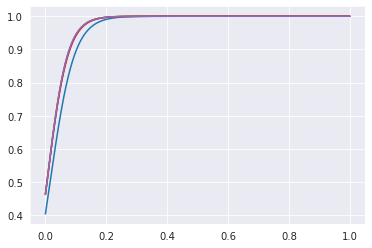

In [26]:
fig, ax = plt.subplots()
for clf in classifiers:
    plt.plot(np.arange(0, 1, .001), clf.predict_proba(np.atleast_2d(np.arange(0, 1, .001)).T)[:, 1])
plt.show()

In [27]:
from sklearn.metrics import f1_score, precision_score, recall_score

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset: assembly
F1: 0.2779966235227912
Precision: 0.9391634980988594
Recall: 0.16314398943196828
Num Predicted: 263
Dataset: dual
F1: 0.8444444444444443
Precision: 0.7307692307692307
Recall: 1.0
Num Predicted: 26
Dataset: gis
F1: 0.6486486486486486
Precision: 0.6666666666666666
Recall: 0.631578947368421
Num Predicted: 18
Dataset: hmp
F1: 0.6575342465753425
Precision: 0.7272727272727273
Recall: 0.6
Num Predicted: 33
Dataset: mbarc
F1: 0.8695652173913044
Precision: 1.0
Recall: 0.7692307692307693
Num Predicted: 20


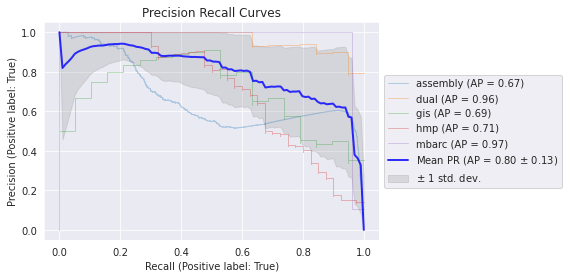

In [28]:
fig, ax = plt.subplots()
for i, ((train, test), classifier) in enumerate(zip(cv.split(X, y), classifiers)):
    viz = plot_precision_recall_curve(classifier, X.loc[test], y.loc[test],
                     name=f'{categories[i]}',
                     alpha=0.3, lw=1, ax=ax)
    interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
    interp_precision[0] = 1.0
    precisions.append(interp_precision)
    average_precisions.append(viz.average_precision)
    y_pred = classifier.predict(X.loc[test])
    print(f"Dataset: {categories[i]}")
    print(f"F1: {f1_score(y.loc[test], y_pred)}")
    print(f"Precision: {precision_score(y.loc[test], y_pred)}")
    print(f"Recall: {recall_score(y.loc[test], y_pred)}")
    print(f"Num Predicted: {y_pred.sum()}")
    

mean_precision = np.mean(precisions, axis=0)
mean_precision[-1] = 0.0
mean_average_precisions = np.mean(average_precisions)
std_average_precisions = np.std(average_precisions)

ax.plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_average_precisions, std_average_precisions),
        lw=2, alpha=.8)

mean_recall_cap = mean_recall.copy()
mean_precision_cap = mean_precision.copy()
mean_average_precisions_cap = mean_average_precisions.copy()
std_average_precisions_cap = std_average_precisions.copy()

# calculate the no skill line as the proportion of the positive class
# no_skill = len(y[y==False]) / len(y)
# # plot the no skill precision-recall curve
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ( AP = {no_skill:.5f})')

std_precisions = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precisions, 1)
precisions_lower = np.maximum(mean_precision - std_precisions, 0)
ax.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
precisions_upper_cap = precisions_upper.copy()
precisions_lower_cap = precisions_lower.copy()

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Precision Recall Curves")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [29]:
features = ['hits',
 'percent_coverage',
 'mean_coverage',
 'sd_coverage',
 'percent_binned_coverage',
 'mean_binned_coverage',
 'sd_binned_coverage',
 'expected_percent_coverage',
 'shannon_entropy',
 'percent_max_uncovered_region',
 'largest_pileup',
 'largest_binned_pileup',
 'gc_content',
 'total_genome_length',
 'ungapped_genome_length',
 'num_n_groups',
 'consecutive_ns',
 'tree_dist',
 'tree_top_dist',
 'gf_checkm_completeness',
 'gf_checkm_contamination',
 'relative_abundance',
 'tree_hits',
 'tree_percent_coverage',
 'tree_mean_coverage',
 'tree_sd_coverage',
 'tree_percent_binned_coverage',
 'tree_mean_binned_coverage',
 'tree_sd_binned_coverage',
 'tree_expected_percent_coverage',
 'tree_shannon_entropy',
 'tree_percent_max_uncovered_region',
 'tree_largest_pileup',
 'tree_largest_binned_pileup',
 'tree_dist',
 'tree_top_dist'
]

# features = [
#  'gf_checkm_completeness',
#  'gf_checkm_contamination',
#  'tree_relative_abundance'
# ]

# features = ['relative_abundance']

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
X = df_train[features + ["assembly_accession", "dataset", "truth", "dataset_cat"]]

# X = X.replace([np.inf, -np.inf], np.nan)
# X = X.loc[:, features].dropna()

cv = PredefinedSplit(X['dataset_cat'].cat.codes)
X = X.loc[:, features].copy()
X.reset_index(inplace=True, drop=True)

y = df_train.loc[:, "truth"]
y.reset_index(inplace=True, drop=True)

In [68]:
VarianceThreshold(threshold=0.1).fit_transform(X).shape

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(38178, 28)

In [31]:
from sklearn.feature_selection import RFECV

# rfc = RandomForestClassifier(n_estimators=100, max_features=.2, min_samples_leaf=17, min_samples_split=9, bootstrap=False, criterion="gini", class_weight="balanced")

logistic = LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")

min_features_to_select = 5

rfecv = RFECV(logistic, step=1, cv=cv, scoring="f1", min_features_to_select=min_features_to_select, n_jobs=40)
rfecv.fit(X, y)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/s

RFECV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 2])),
      estimator=LogisticRegression(class_weight='balanced', penalty='l1',
                                   solver='liblinear', tol=0.001),
      min_features_to_select=5, n_jobs=40, scoring='f1')

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Optimal number of features : 19


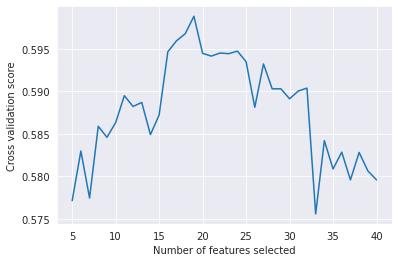

In [32]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig, ax = plt.subplots()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

pu.save_plot(fig, "rfcev")

In [33]:
# df_X_transf

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE


exported_pipeline = make_pipeline(
    RFE(LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")),
    
    MinMaxScaler(),
    MLPClassifier(alpha=0.01, learning_rate_init=0.01)
)

In [72]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier

precisions = []
average_precisions = []
mean_recall = np.linspace(0, 1, 100)
classifiers = []

# columns = rfecv.ranking_

# df_X_transf = pd.DataFrame(X_transf[:, columns == 1], columns = X.columns[columns == 1])

# X_transf = rfecv.transform(X)
# X_transf = X_transf.copy().values
X_transf = X.copy().values
# X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)

for i, (train, test) in enumerate(cv.split(X_transf, y)):
#     clf = RandomForestClassifier(n_estimators=100, max_features=.2, min_samples_leaf=17, min_samples_split=9, bootstrap=False, criterion="gini", class_weight="balanced_subsample")
#     clf = ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_features=0.8, min_samples_leaf=4, min_samples_split=20, n_estimators=100)
#     clf = make_pipeline(
#             MinMaxScaler(),
#             RFECV(LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced"), step=1, cv=StratifiedKFold(random_state=930525, shuffle=True), scoring="f1", min_features_to_select=5, n_jobs=40),
#             MLPClassifier(alpha=0.01, learning_rate_init=0.01)
# #         )
#     clf = make_pipeline(
# #         MinMaxScaler(),
# #         RFE(LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")),
#         StackingEstimator(estimator=XGBClassifier(learning_rate=0.01, max_depth=5, min_child_weight=13, n_estimators=100, n_jobs=1, scale_pos_weight=50, subsample=0.6500000000000001, verbosity=0)),
#         ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion="gini", max_features=0.45, min_samples_leaf=19, min_samples_split=14, n_estimators=100)
#     )

    clf = make_pipeline(
        VarianceThreshold(threshold=0.1),
        ZeroCount(),
        RFE(LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")),
        StackingEstimator(estimator=
            GradientBoostingClassifier(learning_rate=1.0, max_depth=2, max_features=0.7000000000000001, min_samples_leaf=20, min_samples_split=5, n_estimators=100, subsample=0.05)),
            RandomForestClassifier(bootstrap=True, class_weight=None, criterion="gini", max_features=1.0, min_samples_leaf=8, min_samples_split=15, n_estimators=100)
)

#     clf = LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")
    clf.fit(X_transf[train], y.loc[train])
    classifiers.append(clf)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number

# Save classifier from entire pipeline

In [36]:
import joblib

clf = make_pipeline(
        MinMaxScaler(),
        RFECV(LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced"), step=1, cv=StratifiedKFold(random_state=930525, shuffle=True), scoring="f1", min_features_to_select=5, n_jobs=40),
        MLPClassifier(alpha=0.01, learning_rate_init=0.01))
clf.fit(X_transf[train], y.loc[train])

joblib.dump(clf, '../data/clf.sklearn.all.pkl', compress=9)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['../data/clf.sklearn.all.pkl']

In [39]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier

clf = make_pipeline(
    StackingEstimator(estimator=XGBClassifier(learning_rate=0.01, max_depth=5, min_child_weight=13, n_estimators=100, n_jobs=1, scale_pos_weight=50, subsample=0.6500000000000001, verbosity=0)),
    ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion="gini", max_features=0.45, min_samples_leaf=19, min_samples_split=14, n_estimators=100)
)


In [43]:
import joblib

for i, classifier in enumerate(classifiers):
    joblib.dump(classifier, f'../data/clf.sklearn.{categories[i]}.pkl', compress=9)
    
joblib.dump(X_transf, f'../data/X.pkl', compress=9)
joblib.dump(y, f'../data/y.pkl', compress=9)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['../data/y.pkl']

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset: assembly
F1: 0.8025964108438336
Precision: 0.951131221719457
Recall: 0.6941875825627477
Num Predicted: 1105
Dataset: dual
F1: 0.8947368421052632
Precision: 0.8947368421052632
Recall: 0.8947368421052632
Num Predicted: 19
Dataset: gis
F1: 0.7450980392156863
Precision: 0.59375
Recall: 1.0
Num Predicted: 32
Dataset: hmp
F1: 0.8378378378378379
Precision: 0.9117647058823529
Recall: 0.775
Num Predicted: 34
Dataset: mbarc
F1: 0.9056603773584906
Precision: 0.8888888888888888
Recall: 0.9230769230769231
Num Predicted: 27


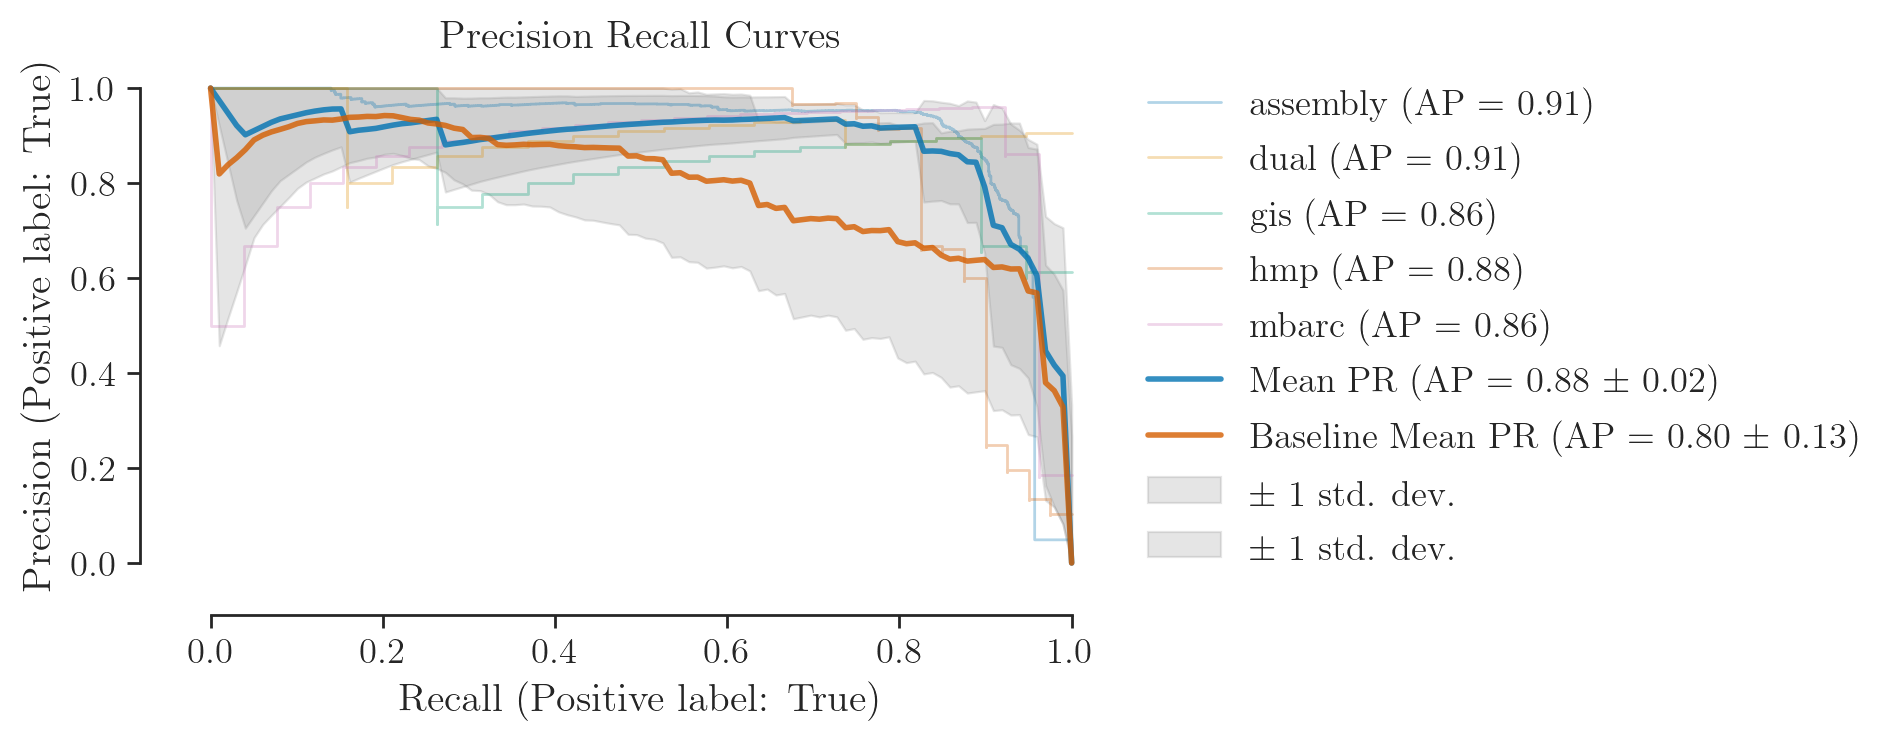

In [73]:
sns.set(context="paper", style="ticks", palette="colorblind", font='serif', font_scale=1.5, color_codes=True, rc=pu.figure_setup())

ax.yaxis.grid(True)
ax.xaxis.grid(False)
fig_size = pu.get_fig_size(15, 10)

fig, ax = plt.subplots(figsize=fig_size)

for i, ((train, test), classifier) in enumerate(zip(cv.split(X_transf, y), classifiers)):
    viz = plot_precision_recall_curve(classifier, X_transf[test], y.loc[test],
                     name=f'{categories[i]}',
                     alpha=0.3, lw=1, ax=ax)
    interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
    interp_precision[0] = 1.0
    precisions.append(interp_precision)
    average_precisions.append(viz.average_precision)
    y_pred = classifier.predict(X_transf[test])
    print(f"Dataset: {categories[i]}")
    print(f"F1: {f1_score(y.loc[test], y_pred)}")
    print(f"Precision: {precision_score(y.loc[test], y_pred)}")
    print(f"Recall: {recall_score(y.loc[test], y_pred)}")
    print(f"Num Predicted: {y_pred.sum()}")
    

mean_precision = np.mean(precisions, axis=0)
mean_precision[-1] = 0.0
mean_average_precisions = np.mean(average_precisions)
std_average_precisions = np.std(average_precisions)

ax.plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_average_precisions, std_average_precisions),
        lw=2, alpha=.8)

ax.plot(mean_recall_cap, mean_precision_cap, color='r',
        label=r'Baseline Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_average_precisions_cap, std_average_precisions_cap),
        lw=2, alpha=.8)

# calculate the no skill line as the proportion of the positive class
# no_skill = len(y[y==False]) / len(y)
# # plot the no skill precision-recall curve
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ( AP = {no_skill:.5f})')

std_precisions = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precisions, 1)
precisions_lower = np.maximum(mean_precision - std_precisions, 0)
ax.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.fill_between(mean_recall_cap, precisions_lower_cap, precisions_upper_cap, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Precision Recall Curves")


pu.stylize_axes(ax)
pu.stylize_fig(fig)
plt.tight_layout()

artists = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
artists.set_frame_on(False)

pu.save_plot(fig, "pr_curves", artists=(artists,))

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number

Dataset: mbarc
F1: 0.9411764705882353
Precision: 0.96
Recall: 0.9230769230769231
Num Predicted: 25


/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Dataset: mbarc
F1: 0.7142857142857143
Precision: 0.5681818181818182
Recall: 0.9615384615384616
Num Predicted: 44


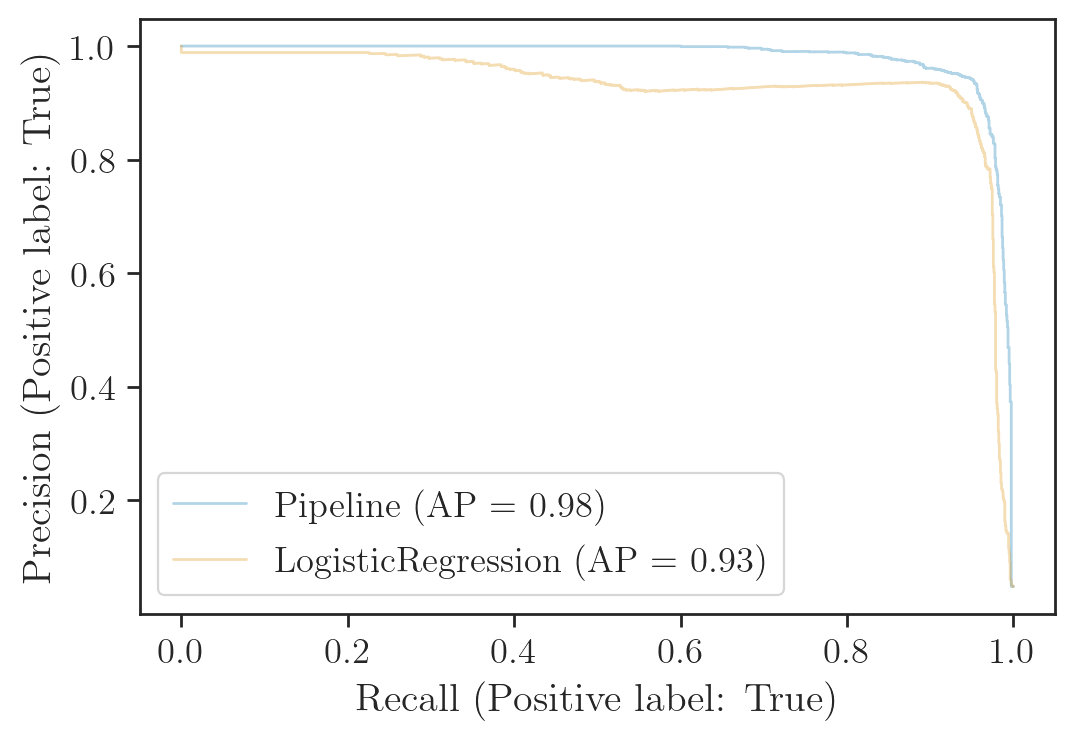

In [74]:
fig, ax = plt.subplots(figsize=fig_size)

classifier = clf.fit(X_transf, y)

X_test = df_test[features + ["assembly_accession", "dataset", "truth", "dataset_cat"]]
X_test = X_test.loc[:, features].copy()
X_test.reset_index(inplace=True, drop=True)

y_test = df_test.loc[:, "truth"]
y_test.reset_index(inplace=True, drop=True)

viz = plot_precision_recall_curve(classifier, X_test, y_test, alpha=0.3, lw=1, ax=ax)
interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
interp_precision[0] = 1.0
precisions.append(interp_precision)
average_precisions.append(viz.average_precision)
y_pred = classifier.predict(X_transf[test])
print(f"Dataset: {categories[i]}")
print(f"F1: {f1_score(y.loc[test], y_pred)}")
print(f"Precision: {precision_score(y.loc[test], y_pred)}")
print(f"Recall: {recall_score(y.loc[test], y_pred)}")
print(f"Num Predicted: {y_pred.sum()}")

classifier = logistic.fit(X_transf, y)

viz = plot_precision_recall_curve(classifier, X_test, y_test, alpha=0.3, lw=1, ax=ax)
interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
interp_precision[0] = 1.0
precisions.append(interp_precision)
average_precisions.append(viz.average_precision)
y_pred = classifier.predict(X_transf[test])
print(f"Dataset: {categories[i]}")
print(f"F1: {f1_score(y.loc[test], y_pred)}")
print(f"Precision: {precision_score(y.loc[test], y_pred)}")
print(f"Recall: {recall_score(y.loc[test], y_pred)}")
print(f"Num Predicted: {y_pred.sum()}")

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset: assembly
F1: 0.8025964108438336
Precision: 0.951131221719457
Recall: 0.6941875825627477
Num Predicted: 1105
Dataset: dual
F1: 0.8947368421052632
Precision: 0.8947368421052632
Recall: 0.8947368421052632
Num Predicted: 19
Dataset: gis
F1: 0.7450980392156863
Precision: 0.59375
Recall: 1.0
Num Predicted: 32
Dataset: hmp
F1: 0.8378378378378379
Precision: 0.9117647058823529
Recall: 0.775
Num Predicted: 34
Dataset: mbarc
F1: 0.9411764705882353
Precision: 0.96
Recall: 0.9230769230769231
Num Predicted: 25


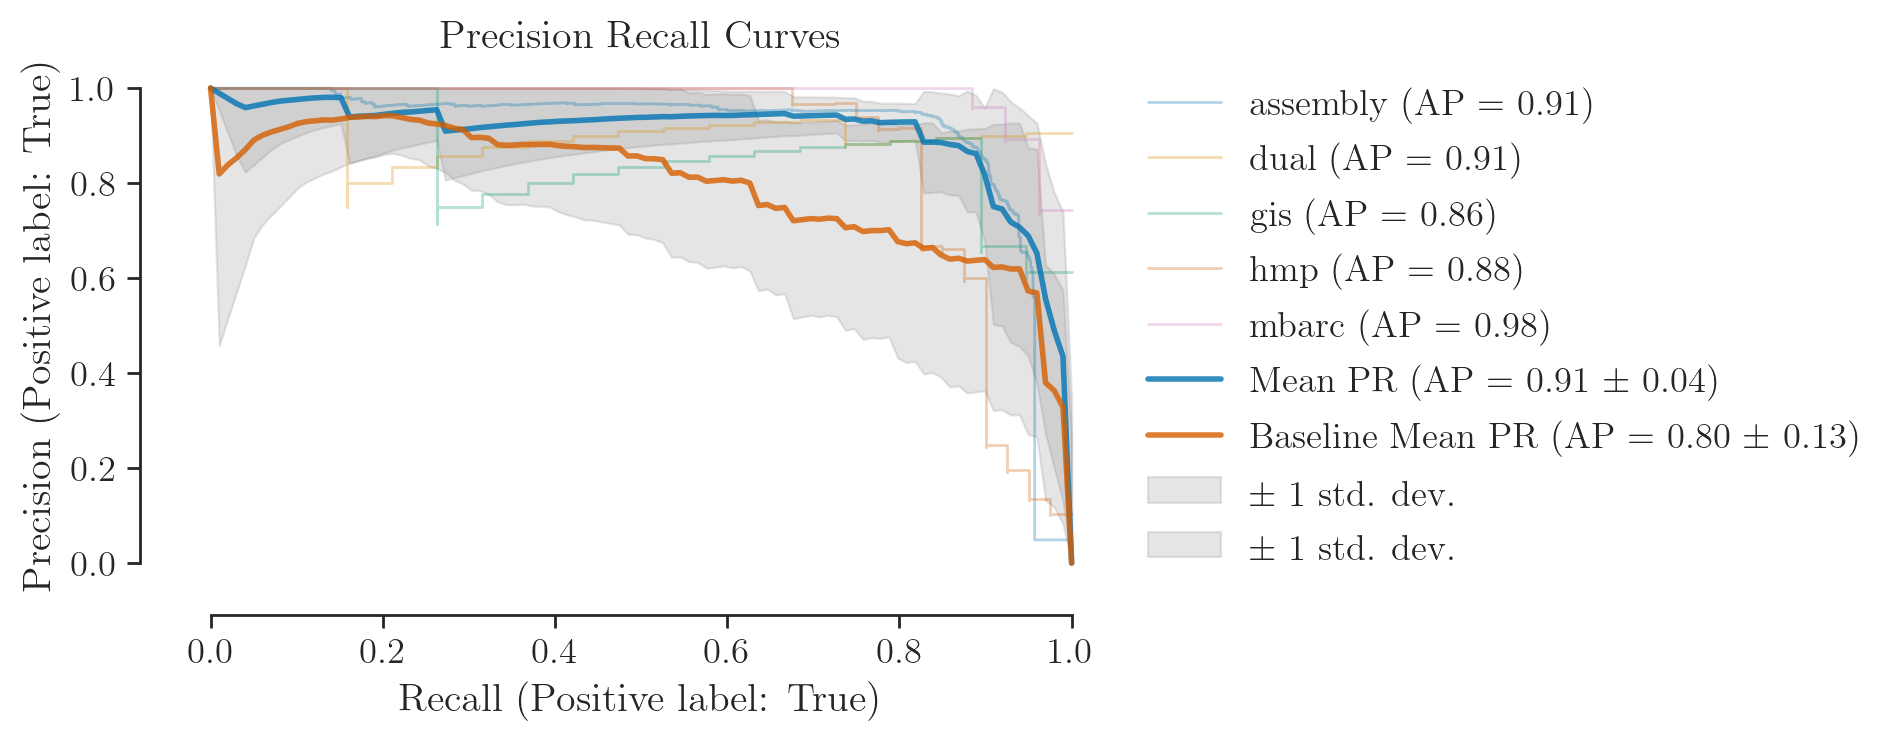

In [75]:
sns.set(context="paper", style="ticks", palette="colorblind", font='serif', font_scale=1.5, color_codes=True, rc=pu.figure_setup())

ax.yaxis.grid(True)
ax.xaxis.grid(False)
fig_size = pu.get_fig_size(15, 10)

fig, ax = plt.subplots(figsize=fig_size)

for i, ((train, test), classifier) in enumerate(zip(cv.split(X_transf, y), classifiers)):
    viz = plot_precision_recall_curve(classifier, X_transf[test], y.loc[test],
                     name=f'{categories[i]}',
                     alpha=0.3, lw=1, ax=ax)
    interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
    interp_precision[0] = 1.0
    precisions.append(interp_precision)
    average_precisions.append(viz.average_precision)
    y_pred = classifier.predict(X_transf[test])
    print(f"Dataset: {categories[i]}")
    print(f"F1: {f1_score(y.loc[test], y_pred)}")
    print(f"Precision: {precision_score(y.loc[test], y_pred)}")
    print(f"Recall: {recall_score(y.loc[test], y_pred)}")
    print(f"Num Predicted: {y_pred.sum()}")
    

mean_precision = np.mean(precisions, axis=0)
mean_precision[-1] = 0.0
mean_average_precisions = np.mean(average_precisions)
std_average_precisions = np.std(average_precisions)

ax.plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_average_precisions, std_average_precisions),
        lw=2, alpha=.8)

ax.plot(mean_recall_cap, mean_precision_cap, color='r',
        label=r'Baseline Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_average_precisions_cap, std_average_precisions_cap),
        lw=2, alpha=.8)

# calculate the no skill line as the proportion of the positive class
# no_skill = len(y[y==False]) / len(y)
# # plot the no skill precision-recall curve
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ( AP = {no_skill:.5f})')

std_precisions = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precisions, 1)
precisions_lower = np.maximum(mean_precision - std_precisions, 0)
ax.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.fill_between(mean_recall_cap, precisions_lower_cap, precisions_upper_cap, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Precision Recall Curves")


pu.stylize_axes(ax)
pu.stylize_fig(fig)
plt.tight_layout()

artists = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
artists.set_frame_on(False)

pu.save_plot(fig, "pr_curves", artists=(artists,))

In [45]:
classifier_config_dict = {

    # Classifiers
    'sklearn.naive_bayes.GaussianNB': {
    },

    'sklearn.naive_bayes.BernoulliNB': {
        'alpha': [1e-3, 1e-2, 1e-1, 1., 10., 100.],
        'fit_prior': [True, False]
    },

    'sklearn.naive_bayes.MultinomialNB': {
        'alpha': [1e-3, 1e-2, 1e-1, 1., 10., 100.],
        'fit_prior': [True, False]
    },

    'sklearn.tree.DecisionTreeClassifier': {
        'criterion': ["gini", "entropy"],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    },

    'sklearn.ensemble.ExtraTreesClassifier': {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False],
        'class_weight': ['balanced', 'balanced_subsample', None]
    },

    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf':  range(1, 21),
        'bootstrap': [True, False],
        'class_weight': ['balanced', 'balanced_subsample', None]
    },

    'sklearn.ensemble.GradientBoostingClassifier': {
        'n_estimators': [100],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05)
    },

    'sklearn.neighbors.KNeighborsClassifier': {
        'n_neighbors': range(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },

    'sklearn.svm.LinearSVC': {
        'penalty': ["l1", "l2"],
        'loss': ["hinge", "squared_hinge"],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]
    },



    'xgboost.XGBClassifier': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [1],
        'verbosity': [0],
        'scale_pos_weight': [1, 10, 25, 50, 75, 99, 100, 1000]
    },

    'sklearn.linear_model.SGDClassifier': {
        'loss': ['log', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
        'penalty': ['elasticnet'],
        'alpha': [0.0, 0.01, 0.001],
        'learning_rate': ['invscaling', 'constant'],
        'fit_intercept': [True, False],
        'l1_ratio': [0.25, 0.0, 1.0, 0.75, 0.5],
        'eta0': [0.1, 1.0, 0.01],
        'power_t': [0.5, 0.0, 1.0, 0.1, 100.0, 10.0, 50.0]
    },

    'sklearn.neural_network.MLPClassifier': {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
        'learning_rate_init': [1e-3, 1e-2, 1e-1, 0.5, 1.]
    },

    # Preprocesssors
    'sklearn.preprocessing.Binarizer': {
        'threshold': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.decomposition.FastICA': {
        'tol': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.cluster.FeatureAgglomeration': {
        'linkage': ['ward', 'complete', 'average'],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    },

    'sklearn.preprocessing.MaxAbsScaler': {
    },

    'sklearn.preprocessing.MinMaxScaler': {
    },

    'sklearn.preprocessing.Normalizer': {
        'norm': ['l1', 'l2', 'max']
    },

    'sklearn.kernel_approximation.Nystroem': {
        'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
        'gamma': np.arange(0.0, 1.01, 0.05),
        'n_components': range(1, 11)
    },

    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.preprocessing.PolynomialFeatures': {
        'degree': [2],
        'include_bias': [False],
        'interaction_only': [False]
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },

    'tpot.builtins.ZeroCount': {
    },

    'tpot.builtins.OneHotEncoder': {
        'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
        'sparse': [False],
        'threshold': [10]
    },

    # Selectors
    'sklearn.feature_selection.SelectFwe': {
        'alpha': np.arange(0, 0.05, 0.001),
        'score_func': {
            'sklearn.feature_selection.f_classif': None
        }
    },

    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_classif': None
        }
    },

    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    },

    'sklearn.feature_selection.RFE': {
        'step': np.arange(0.05, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesClassifier': {
                'n_estimators': [100],
                'criterion': ['gini', 'entropy'],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'class_weight': ['balanced', 'balanced_subsample', None]
            }
        }
    },

    'sklearn.feature_selection.SelectFromModel': {
        'threshold': np.arange(0, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesClassifier': {
                'n_estimators': [100],
                'criterion': ['gini', 'entropy'],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'class_weight': ['balanced', 'balanced_subsample', None]
            }
        }
    }

}

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# RandomForestClassifier(input_matrix, bootstrap=False, class_weight=None, criterion=gini, max_features=0.45, min_samples_leaf=2, min_samples_split=12, n_estimators=100)

In [49]:
X_transf.shape

X_tpot = rfecv.transform(X)

In [51]:
X_tpot.shape

(38178, 19)

In [ ]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=30, population_size=80, verbosity=2, random_state=42, n_jobs=40, config_dict=classifier_config_dict, cv=cv, scoring='f1')
tpot.fit(X_tpot, y)
# print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline.py')

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Optimization Progress:   0%|          | 0/2480 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.833716747197711

Generation 2 - Current best internal CV score: 0.833716747197711

Generation 3 - Current best internal CV score: 0.841721297501272

Generation 4 - Current best internal CV score: 0.841721297501272

Generation 5 - Current best internal CV score: 0.841721297501272

Generation 6 - Current best internal CV score: 0.8500924334017341

Generation 7 - Current best internal CV score: 0.8500924334017341

Generation 8 - Current best internal CV score: 0.8530084811636554

Generation 9 - Current best internal CV score: 0.8530084811636554

Generation 10 - Current best internal CV score: 0.8530084811636554

Generation 11 - Current best internal CV score: 0.8541878910515441

Generation 12 - Current best internal CV score: 0.8623541461523281

Generation 13 - Current best internal CV score: 0.8623541461523281

Generation 14 - Current best internal CV score: 0.8623541461523281

Generation 15 - Current best internal CV score: 0.86235414615

In [55]:
from tpot.builtins import OneHotEncoder, StackingEstimator, ZeroCount
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [59]:
pipeline = make_pipeline(
    VarianceThreshold(threshold=0.1),
    ZeroCount()
)

In [69]:
np.isclose(OneHotEncoder(minimum_fraction=0.25, sparse=False, threshold=10).fit_transform(X_tpot), X_tpot).all()

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [62]:
pipeline.fit_transform(X_tpot).shape

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(38178, 13)

In [64]:
X_tpot.shape

(38178, 19)

In [70]:
exported_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.1),
    ZeroCount(),
    RFE(LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")),
    StackingEstimator(estimator=
        GradientBoostingClassifier(learning_rate=1.0, max_depth=2, max_features=0.7000000000000001, min_samples_leaf=20, min_samples_split=5, n_estimators=100, subsample=0.05)),
        RandomForestClassifier(bootstrap=True, class_weight=None, criterion="gini", max_features=1.0, min_samples_leaf=8, min_samples_split=15, n_estimators=100)
)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
